# Continuous DBSCAN
This project provides a class for sequential clusternig using DBSCAN algorithm.

fit(dataset): runs DBSCAN algorithm on 2 dimentional data and plots a result
partial_fit(dataset): having alredy clusterized a previous dataset, update clusters with new data

In [18]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
from numpy import square, sqrt
from sklearn import datasets
import shapely
import types
from shapely.geometry import MultiPoint


%matplotlib inline

df = pd.read_csv("datasets/xclara.csv")
x = df.ix[:,0].tolist()
y = df.ix[:,1].tolist()
    
# Initialize set of feature vectors
print("\nSample of feature vector points:")
points = list(zip(x, y))
points[:5]
points_x = [i[0] for i in points]
points_y = [i[1] for i in points]


Sample of feature vector points:


/Users/dimas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
/Users/dimas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [19]:
print(df.head())

          V1         V2
0   2.072345  -3.241693
1  17.936710  15.784810
2   1.083576   7.319176
3  11.120670  14.406780
4  23.711550   2.557729


In [16]:
class DBSCAN:
  def __init__(self, eps = 4, MinPts = 4, weighting = 10, Metric = "Euclidean", Noise = "Yes"):
    self.eps = eps
    self.MinPts = MinPts
    self.weighting = weighting
    self.metric = Metric
    self.Noise = Noise



  #-------------------------------
  #OurDBSCAN Function
  #-------------------------------   
  def fit(self, Dataset):
      noise = [] #Variable to hold noise points
      visited = [] #List to hold points that have been visited
      Clusters = [] #List to hold all the clusters
    

      #Go through all the points in the dataset individually
      for point in Dataset: 
        
          #Check to see if the selected point has already been visited, if so continue
          if point in visited:
            continue
        
          #Find the neighbourhood points of the selected point
          neighbour_points = self.RangeQuery(Dataset, point, self.eps, self.metric)
        
          #Check to see if the amount of point sin neighbourhood is > MinPts, if so then
          #mark the point as noise and continue, else expand Cluster
          if len(neighbour_points) < self.MinPts:
            noise.append(point)
            continue
            
          else:
            Clusters,visited,noise = self.ExpandCluster(Dataset, point, visited, noise, Clusters, neighbour_points, self.eps, self.MinPts)
            
      #add cluster values to scatterplot
      for cluster in Clusters:
        plt.scatter([i[0] for i in cluster],[i[1] for i in cluster],cmap="prism")
    
    
      #Add noise points if "yes", noise points are added in black  
      if self.Noise.lower() == "yes":
        plt.scatter([i[0] for i in noise],[i[1] for i in noise],color = "black")
        plt.title("Our DBSCAN")
        plt.show()
      elif self.Noise.lower() == "no":
        plt.title("Our DBSCAN")
        plt.show()
      else:
        sys.exit("Error: Pass in either \"Yes\" or \"No\" for noise.")
    
      self.clusters = Clusters
      return Clusters
    
    
  #-------------------------------
  #ExpandCluster Function
  #-------------------------------       
  def ExpandCluster(self, Dataset, Point, visited, noise, Clusters, neighbour_points, eps, MinPts):
    temp_Cluster = [] #This list variable will hold all our points for the cluster
    temp_Cluster.append(Point)

    #Go through all the points in the neighbourhood
    for neighbour_point in neighbour_points:  
        if neighbour_point not in visited:
            if neighbour_point in noise:                 
                #Remove point from noise
                noise.remove(neighbour_point)
            visited.append(neighbour_point)
            next_neighbour_points = self.RangeQuery(Dataset,neighbour_point,MinPts, Metric = "Euclidean")
            if len(next_neighbour_points) >= MinPts:
                for i in next_neighbour_points:
                    neighbour_points.append(i)

            #Will append neighbour_point to the cluster if it's not in any other cluster        
            in_cluster = 0
            for clust in Clusters:
                if neighbour_point in clust:
                    in_cluster = 1
                    break
            if in_cluster is 0:
                temp_Cluster.append(neighbour_point)
                

    Clusters.append(temp_Cluster)       
    return Clusters, visited, noise       
    
    
    
    
  #-------------------------------
  #RangeQuery Function
  #-------------------------------
  def RangeQuery(self, Dataset, CorePoint, eps, Metric):
    neighbour_points = []  #Variable to hold all neighbour points of core point
    
    #Go through all the points
    for point in Dataset:
        
        if Metric.lower() == "euclidean":
            
            #Use euclidean distance formula to check distance between points
            dist = sqrt(((CorePoint[0]-point[0])**2)+((CorePoint[1]-point[1])**2))
            
        elif Metric.lower() == "manhattan":
            
            #Use manhattan distance formula to check distance between poin
            dist = (abs(CorePoint[0] - point[0])) + (abs(CorePoint[1] - point[1]))
            
        else:
            
            #Error
            sys.exit("Error: Pass in either \"Euclidean\" or \"Manhattan\" for noise.")
            
            
        #if less then or equal to eps, then point is a neighbour
        if dist <= eps:
            neighbour_points.append(point)
    
    #return the list of neighbour points
    return neighbour_points

  #-------------------------------
  #updateClusters Function ---- partial_fit
  #-------------------------------
  def partial_fit(self, new_dataset, keep_old_clusters=True):

    #Fing clusters in a new dataset
    new_clusters = self.fit(new_dataset)
    final_clusters = []
    old_weights = []
    new_weights = []
    old_clusters = self.clusters

    #Calculate or set clusters' weights
    if  isinstance(self.weighting, types.FunctionType):
      old_weights = self.weighting(old_clusters)
      new_weights = self.weighting(new_clusters)
    elif isinstance(self.weighting, int):
      old_weights = np.full(len(old_clusters), self.weighting)
      new_weights = np.full(len(new_clusters), self.weighting)
    elif isinstance(self.weighting, (list, tuple, np.ndarray)):
      old_weights = self.weighting
      new_weights = np.full(len(new_clusters), self.weighting)
    else:
      old_weights = np.full(len(old_clusters), self.weighting)
      new_weights = np.full(len(new_clusters), self.weighting)

    #Find similar clusters
    for i in range(len(old_clusters)):
      old_weights[i] = int(old_weights[i]*0.9)


      old_cluster_polygon = MultiPoint(old_clusters[i]).convex_hull

      for j in range(len(new_clusters)):
        new_cluster_polygon =  MultiPoint(new_clusters[j]).convex_hull

        #If clusters are similar - unite them
        if new_cluster_polygon.intersection(old_cluster_polygon).area > new_cluster_polygon.area * 0.5:
          old_clusters[i] = list(set(new_clusters[j])|set(old_clusters[i]))
          old_weights[i] = new_weights[j] + old_weights[i]
          new_weights[j] = 0

        elif new_cluster_polygon.intersection(old_cluster_polygon).area > old_cluster_polygon.area * 0.5:
          new_clusters[j] = list(set(new_clusters[j])|set(old_clusters[i]))
          new_weights[j] = new_weights[j] + old_weights[i]
          old_weights[i] = 0

    #If an ununited cluster is heavy enough, it's still important
    if keep_old_clusters:
      for i in range(len(old_weights)):
        old_cluster_polygon = MultiPoint(old_clusters[i]).convex_hull
        if pow(old_weights[i], 3) > old_cluster_polygon.area:
          final_clusters.append(old_clusters[i])

    for i in range(len(new_weights)):
      new_cluster_polygon = MultiPoint(new_clusters[i]).convex_hull
      if pow(new_weights[i], 3) > new_cluster_polygon.area:
        final_clusters.append(new_clusters[i])
  
    #Plot new united set of clusters
    for cluster in final_clusters:
          plt.scatter([i[0] for i in cluster],[i[1] for i in cluster],cmap="prism")
    
    plt.title("Combined clusters")
    plt.show()

    return final_clusters

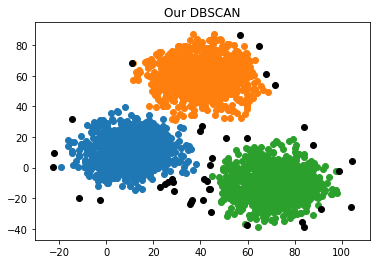

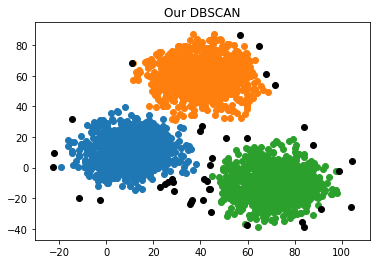

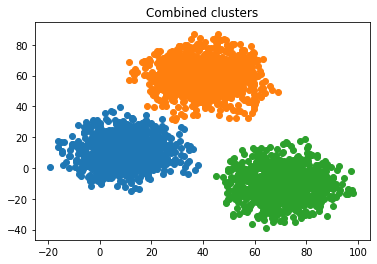

In [17]:
# xclara.csv
DBSCN = DBSCAN(4, 5, Metric = "Euclidean", Noise = "Yes")
cluster1 = DBSCN.fit(points)
weight = np.full(len(cluster1), 10)

# Datasets are seme, so plots have to be also same
twice_processed_clusters = DBSCN.partial_fit(points)